In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint

from collections import Counter

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
segment = 'general_class'
# segment = 'sub_class'
# segment = 'ac_vents'
# segment = 'enclosed_box'
# segment = 'enclosed_cab'
# segment = 'color'
train_dir = 'data/train/{}/train'.format(segment)
validation_dir = 'data/train/{}/validation'.format(segment)
model_fname = '{}.deeper'.format(segment)

In [4]:
image_size=224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Remove the last 4 convolutional layers (aerial images)
vgg_conv.layers.pop()
vgg_conv.layers.pop()
vgg_conv.layers.pop()
vgg_conv.layers.pop()

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0xb52927a20> False
<keras.layers.convolutional.Conv2D object at 0xb52936b70> False
<keras.layers.convolutional.Conv2D object at 0xb41e33160> False
<keras.layers.pooling.MaxPooling2D object at 0xb41e33470> False
<keras.layers.convolutional.Conv2D object at 0xb41e33f28> False
<keras.layers.convolutional.Conv2D object at 0xb5285f240> False
<keras.layers.pooling.MaxPooling2D object at 0xb5287a518> False
<keras.layers.convolutional.Conv2D object at 0xb5287aa58> False
<keras.layers.convolutional.Conv2D object at 0xb52977320> False
<keras.layers.convolutional.Conv2D object at 0xb52992710> False
<keras.layers.pooling.MaxPooling2D object at 0xb529b7400> False
<keras.layers.convolutional.Conv2D object at 0xb529b7a58> True
<keras.layers.convolutional.Conv2D object at 0xb529ed320> True
<keras.layers.convolutional.Conv2D object at 0xb52a09710> True
<keras.layers.pooling.MaxPooling2D object at 0xb52a28400> True


In [8]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         7635264   
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=6,
    width_shift_range=8,
    height_shift_range=16,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.05, 1.2],
    fill_mode='constant')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 20
validation_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=validation_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 9293 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc'])

# Calculate class weight
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

# Save checkpoint when val_loss is minimal
filepath=segment+'.weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


# Train the model
history = model.fit_generator(
      train_generator,
      class_weight=class_weights,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks=callbacks_list,
      verbose=1)
 
# Save the model
model.save(model_fname + '.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Found 2324 images belonging to 2 classes.
233/232 [==============================] - 941s 4s/step
No of errors = 39/2324


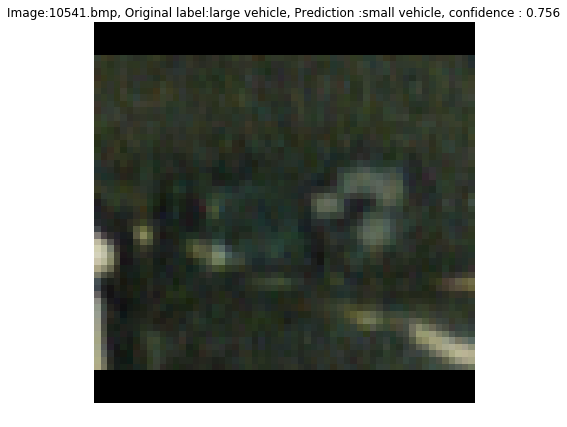

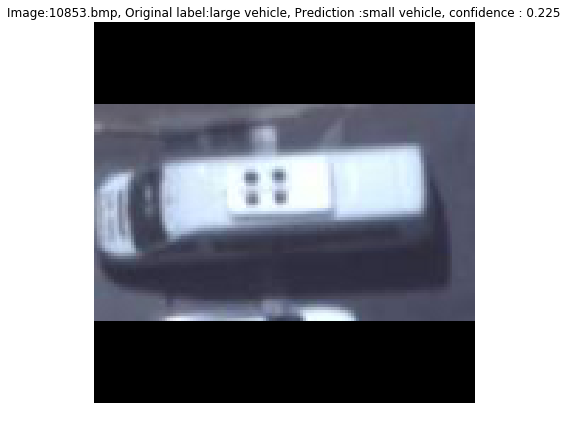

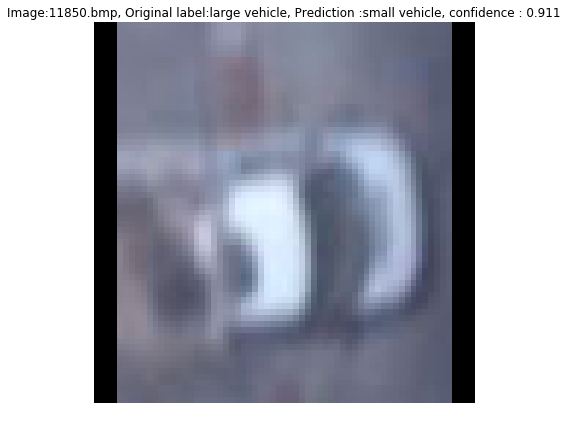

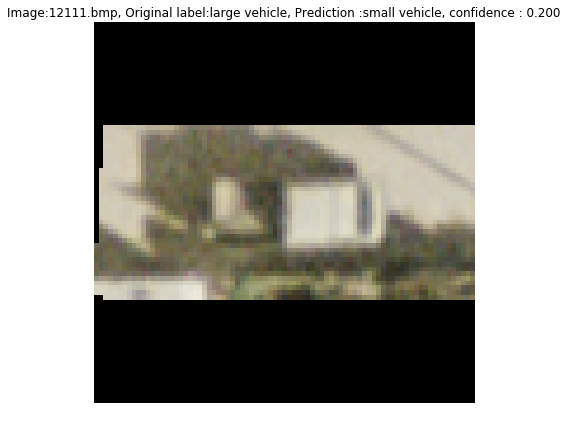

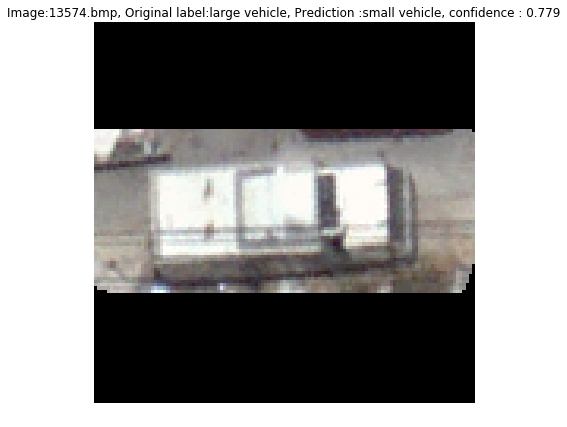

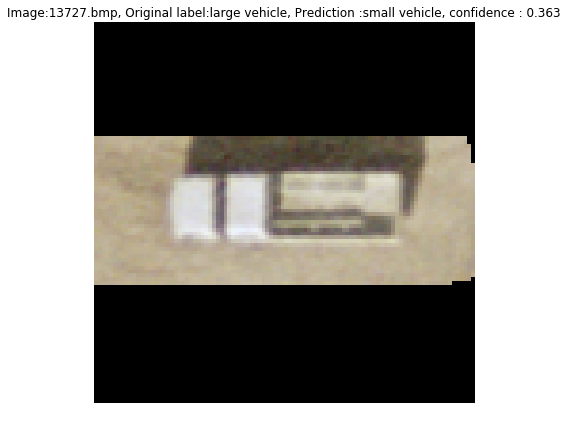

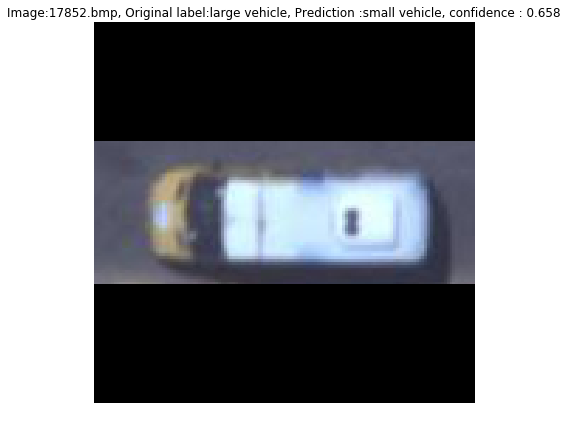

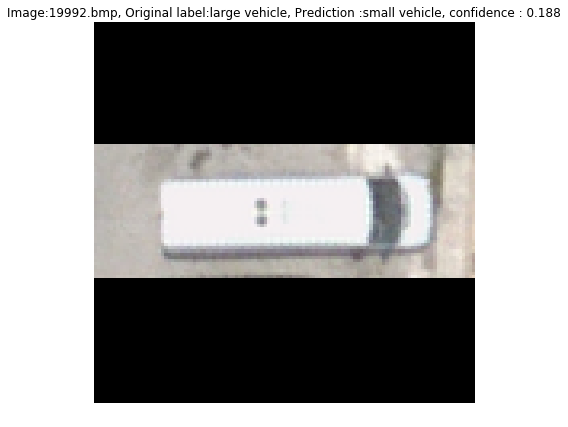

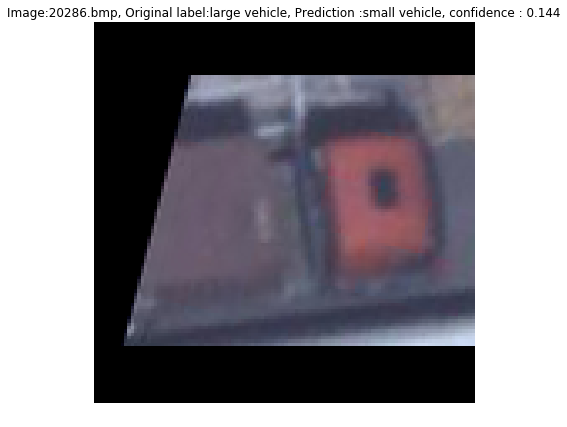

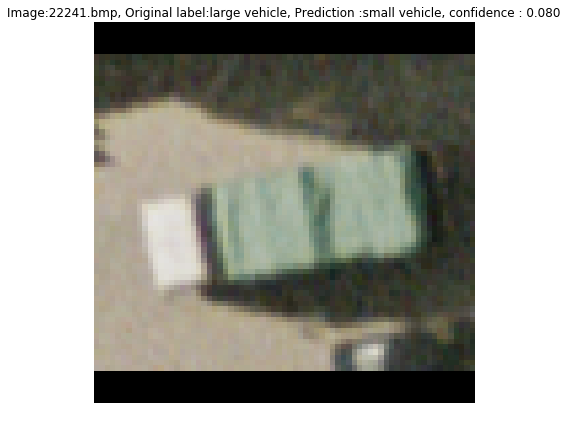

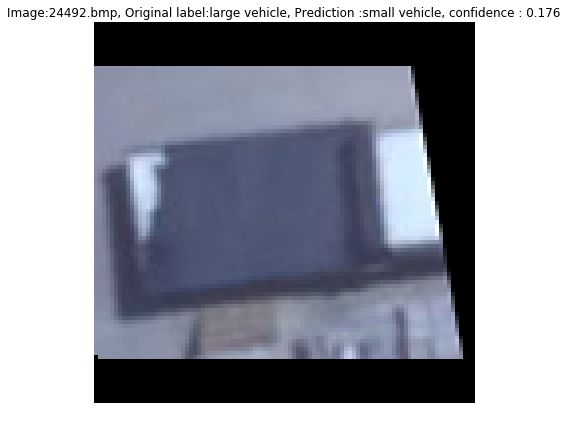

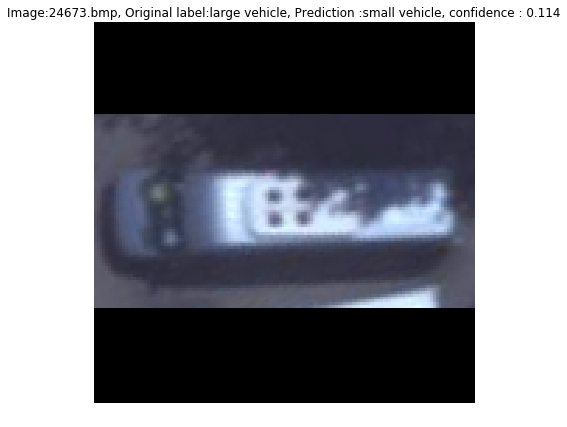

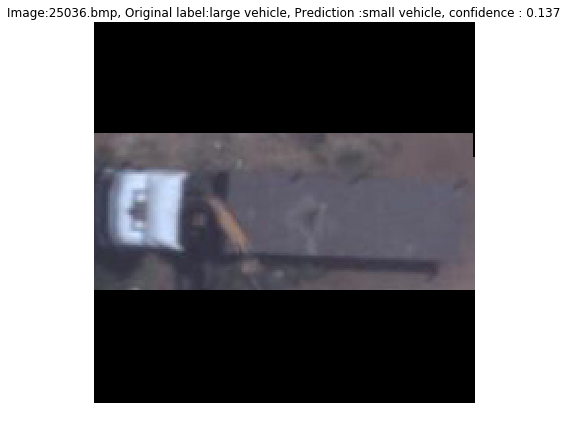

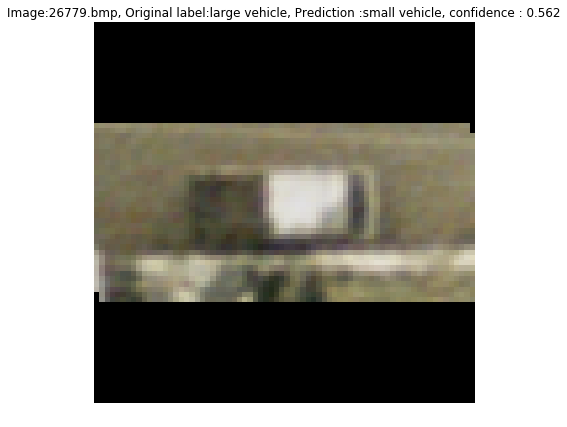

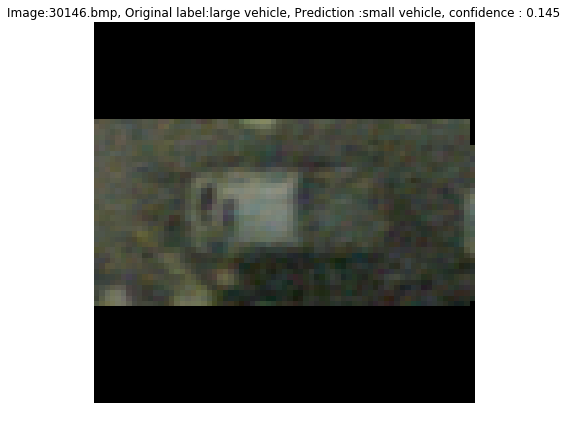

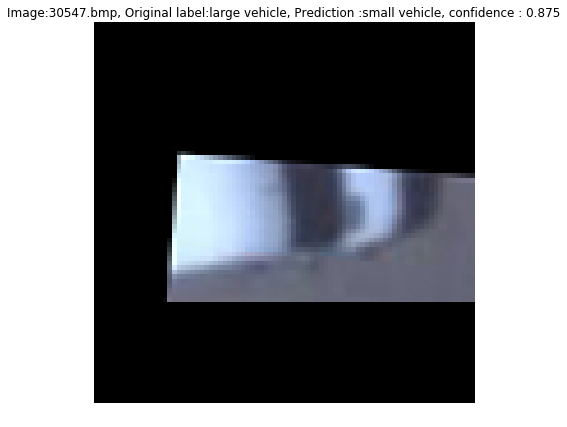

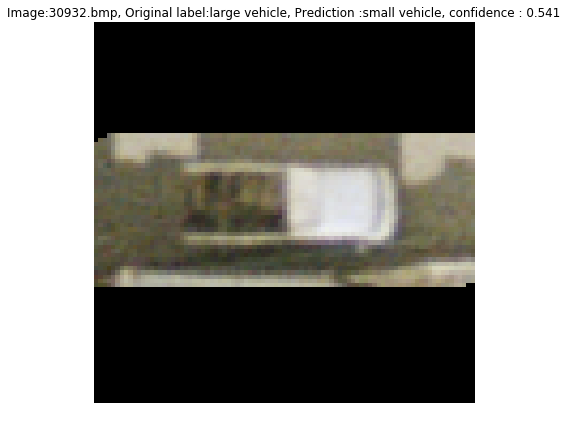

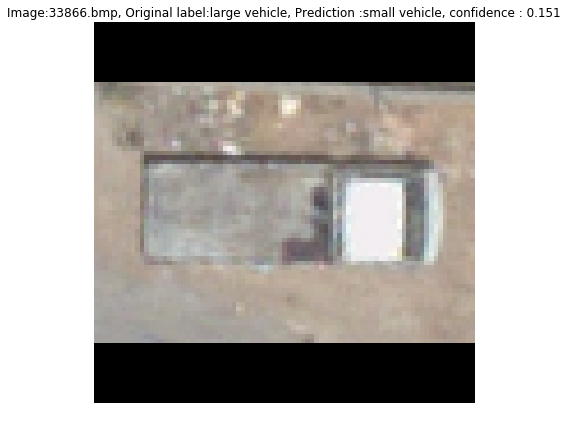

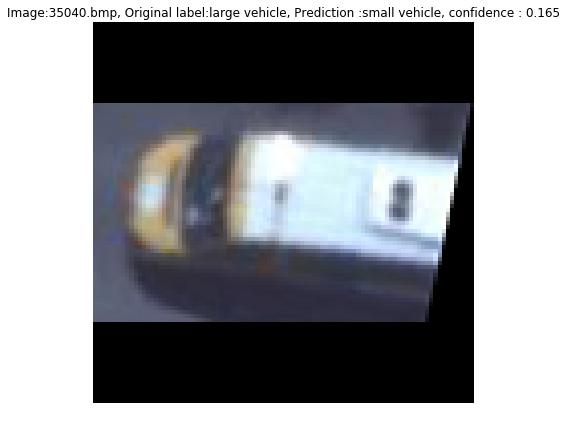

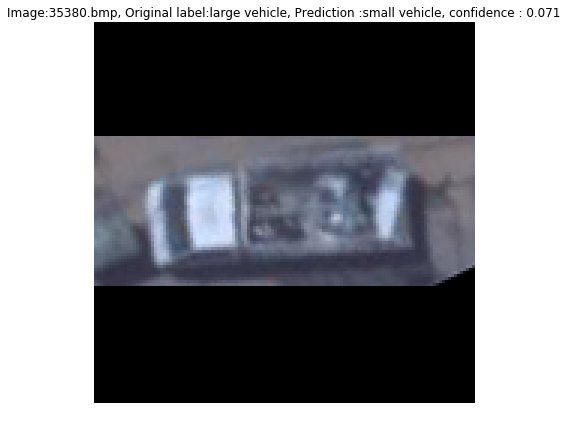

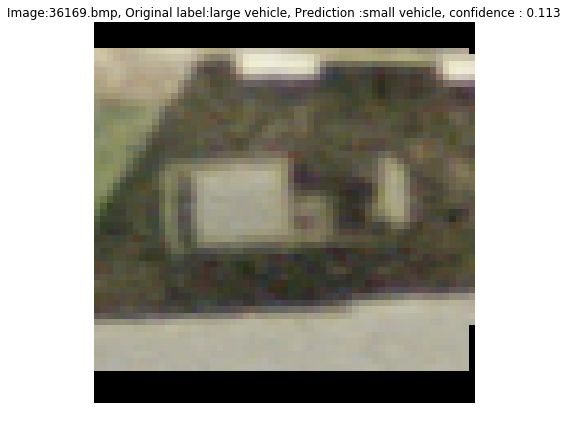

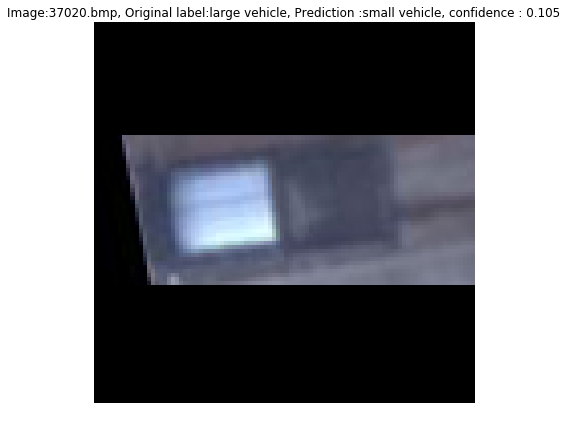

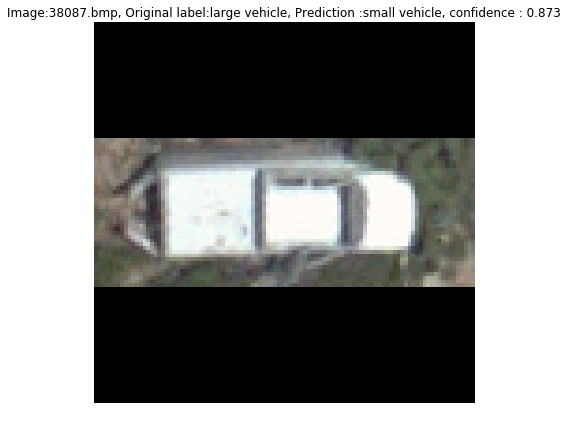

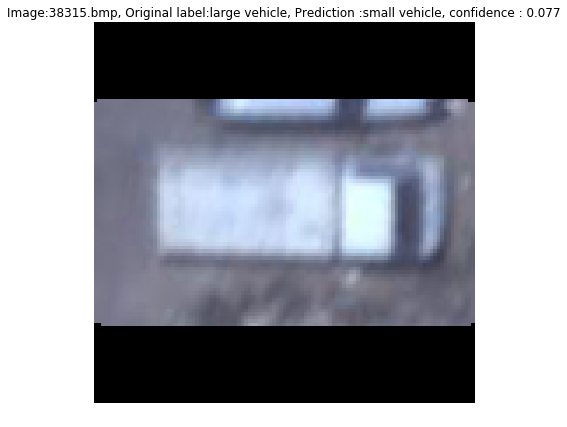

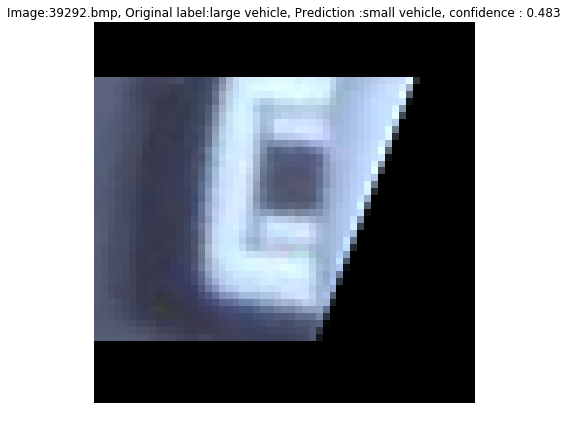

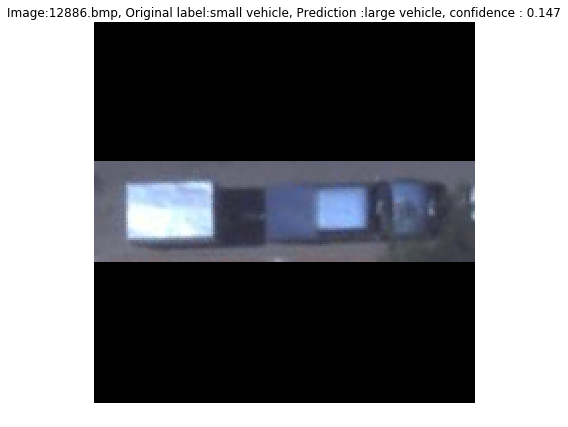

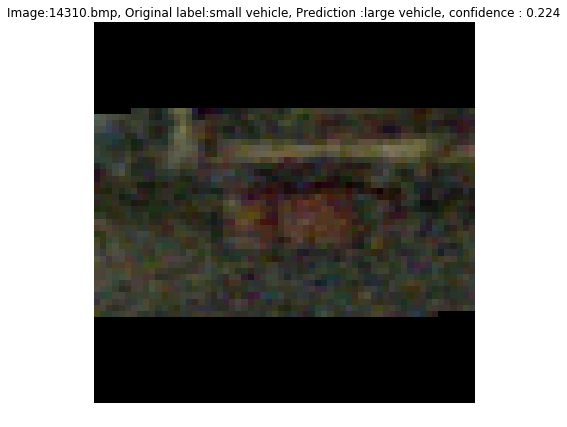

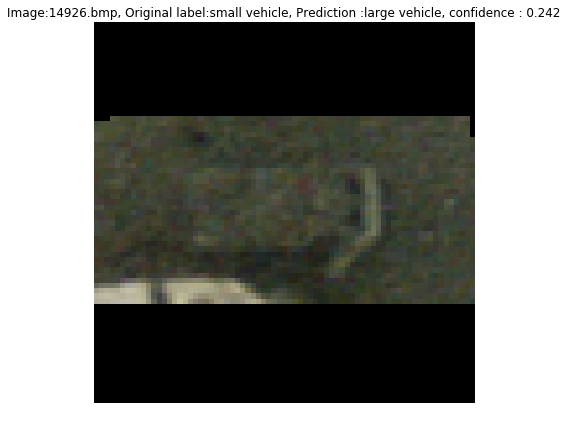

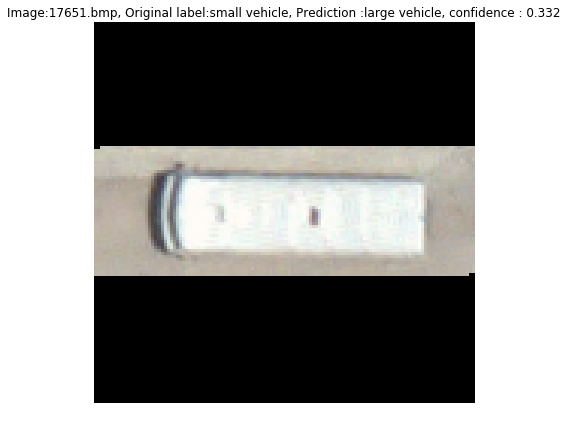

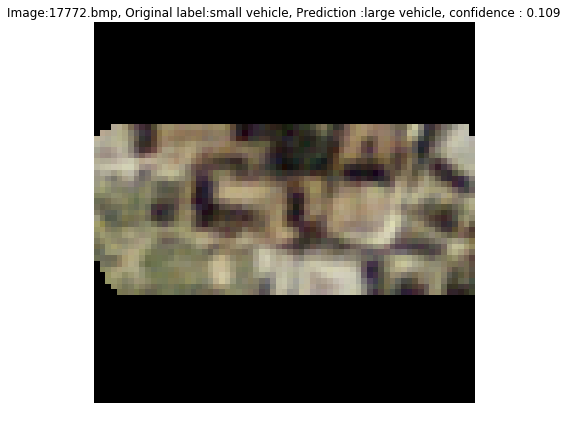

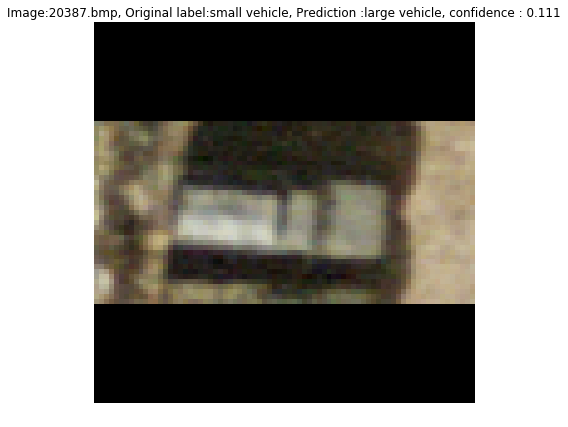

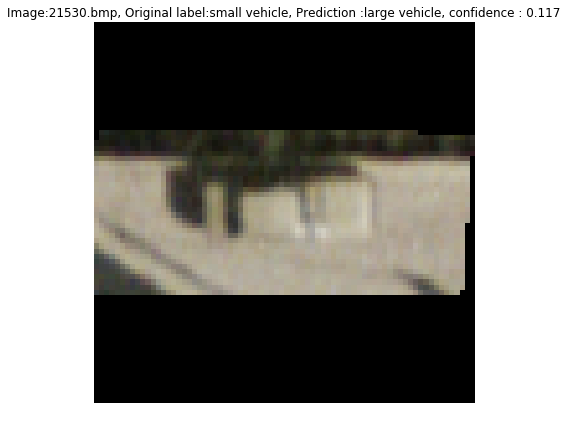

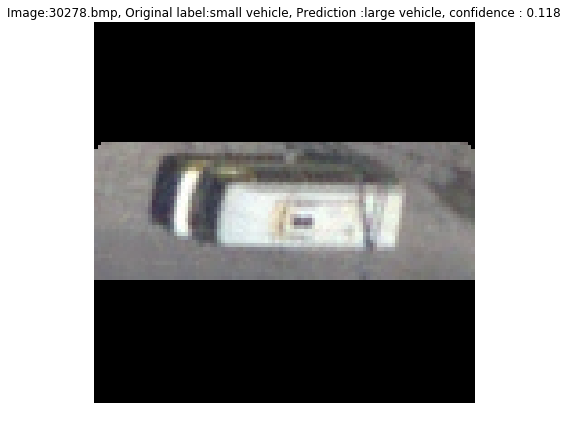

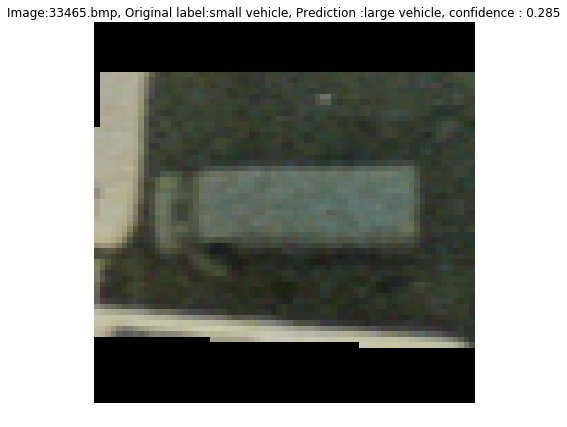

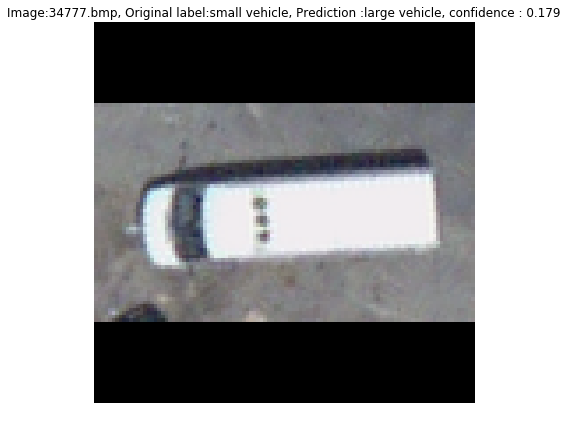

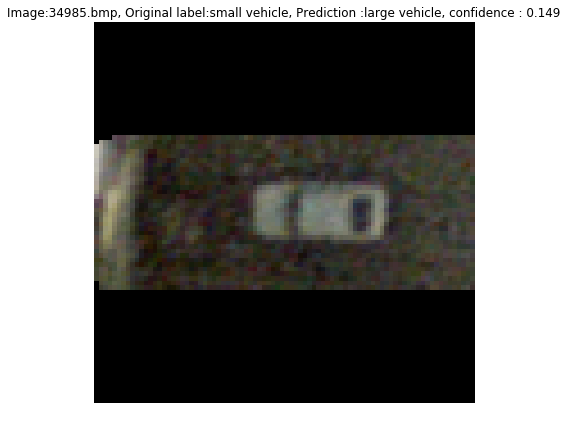

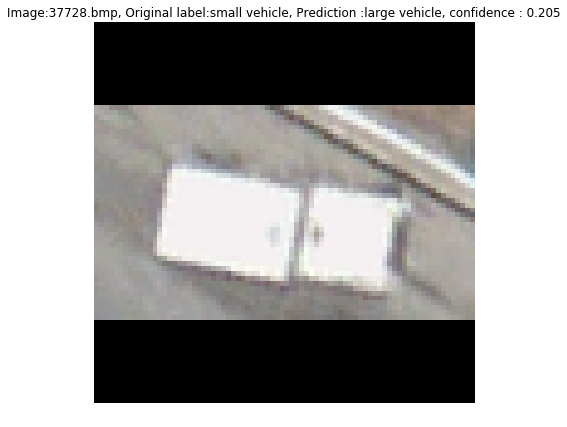

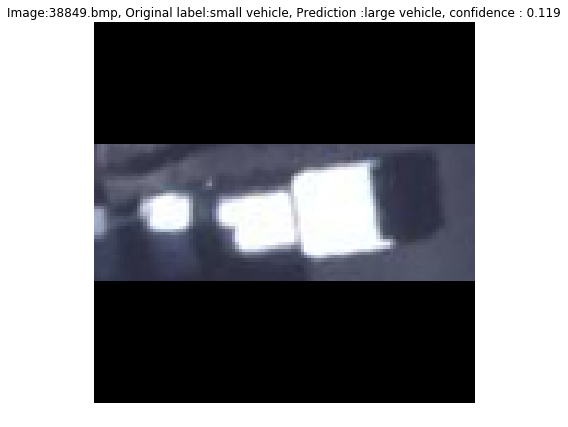

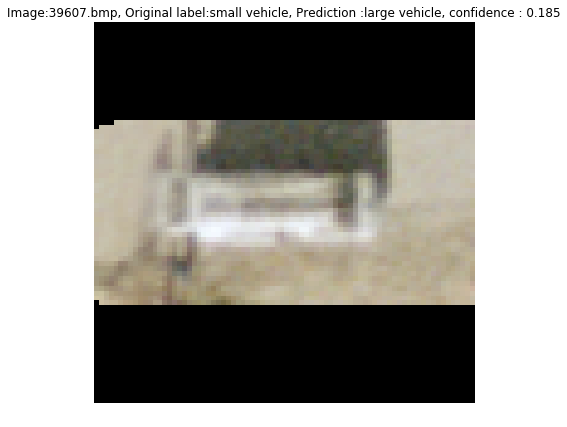

In [13]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

from keras.models import load_model

# model = load_model('balanced_train_general_class.h5')
# result: No of errors = 104/2324

# model = load_model('general_class_retrain_subclass.h5')
# result: No of errors = 124/2324

model = load_model('general_class.weights.50-0.05.hdf5')

# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=validation_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Image:{}, Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[1],
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [61]:
import pandas as pd

segment = 'general_class'
image_size=224
model = load_model('balanced_train_{}.h5'.format(segment))

test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = 'test_mini'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

test_generator.reset()
pred=model.predict_generator(test_generator,steps=test_generator.samples,verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
tag_ids=list(map(lambda x: x.split('/')[1].split('.')[0], filenames))
results=pd.DataFrame({
    "Filename":filenames,
    "Predictions":predictions,
    "prediction_idx":predicted_class_indices,
    "tag_id":tag_ids
})
for idx, label in labels.items():
    results[label] = pred[:,idx]
    
results.to_csv("results_{}.csv".format(segment),index=False)

df_answer = pd.read_csv('answer.csv')

for label in labels.values():
    sorted_by_feature = results.sort_values(by=label, ascending=False)
    tags = sorted_by_feature['tag_id'].tolist()
    df_answer[label] = tags

df_answer.to_csv('answer.csv',index=False)

Found 11 images belonging to 1 classes.
11/11 [==============================] - 6s 583ms/step
